## Jupyter notebook for plotting the log2 foldchange between CHi-C, ATAC-seq and RNA-seq

This notebook is the code for plotting the log2 folchange between CHi-C, ATAC-seq and RNA-seq time course data (Fig. 4b,c) used in the paper **\"Analysis of chromatin organinization and gene expression in T cells identifies functional genes for rheumatoid arthritis\"** by *Jing Yang, Amanda McGovern, Paul Martin, Kate Duffus, Xiangyu Ge, Peyman Zarrineh, Andrew P Morris, Antony Adamson, Peter Fraser, Magnus Rattray & Stephen Eyre*

Author : *Jing Yang*  <br />
Date: 01-05-2019 <br />
For any questions about the code, please drop me a line at Jing.Yang@manchester.ac.uk

### load required packages

In [4]:
library(tidyverse)
library(DESeq2)


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply

### load linked gene expression, open chromatin and interaction data.

In [5]:
data_original <- read.table(file='data/ATACseq_CHiC_RNAseq_linked.txt', header=T)

In [6]:
head(data_original)

,ATACchr,ATACstart,ATACend,otherEndID,otherEndchr,otherEndstart,otherEndend,ID,ENSG,ENSGchr,⋯,AT1H,AT2H,AT4H,AT24H,Alld_ratio0,mean_atacseq,mean_gene,corr_atacseq_gene,corr_atacseq_otherEnd,corr_gene_otherEnd
,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr10,100168185,100168481,94270,chr10,100168142,100171879,7,ENSG00000099204,chr10,⋯,5.549115,5.081706,5.133666,5.469091,-7.960483e-06,5.300782,13.144099,-0.11473015,0.3875610,-0.9240688
2,chr10,100168185,100168481,94270,chr10,100168142,100171879,7,ENSG00000122873,chr10,⋯,5.549115,5.081706,5.133666,5.469091,-7.960483e-06,5.300782,7.386855,0.01408322,-0.6566466,0.3687837
3,chr10,100510838,100511373,94364,chr10,100507722,100518706,23,ENSG00000052749,chr10,⋯,9.971759,8.586541,9.457576,8.248255,-1.622436e-05,9.036950,11.681048,0.05696710,-0.7670981,0.2089518
4,chr10,101814895,101815024,94665,chr10,101813654,101818522,76,ENSG00000047056,chr10,⋯,6.908540,6.233613,6.974758,6.509405,-4.866014e-05,6.395328,10.889609,0.26646359,0.5669826,0.5107519
5,chr10,101814895,101815024,94665,chr10,101813654,101818522,76,ENSG00000107566,chr10,⋯,6.908540,6.233613,6.974758,6.509405,-4.866014e-05,6.395328,8.824033,0.57759985,0.4452978,-0.3354777
6,chr10,101814895,101815024,94665,chr10,101813654,101818522,76,ENSG00000052749,chr10,⋯,6.908540,6.233613,6.974758,6.509405,-4.866014e-05,6.395328,11.681048,0.77571350,0.0847067,0.2089518


In [7]:
data_original$baitpos <- 0.5*(data_original$baitstart + data_original$baitend)
data_original$otherEndpos <- 0.5*(data_original$otherEndstart + data_original$otherEndend)
data_original$distance <- abs(data_original$baitpos - data_original$otherEndpos)

In [8]:
idx <- data_original$baitchr == data_original$otherEndchr

In [9]:
tmp <- data_original[idx,]
data <- subset(tmp, tmp$distance < 5000000)

In [10]:
dim(data)

[1] 23887    81

### get data with dynamic ATACseq

In [9]:
data_dynamic_atacseq <- data

In [10]:
dim(data_dynamic_atacseq)

[1] 23887    81

### load these highly correlated links

In [11]:
data_corrover0.5 <- read.table('data/CHiC_ATACseq_RNAseq_linked_correlationover0.5.txt', header=T)

### load raw reads ATAC-seq, RNA-seq and CHi-C data

In [12]:
counts_chic <- read.table('data/CHiC_counts.txt', header=T)
counts_gene <- read.table('data/RNAseq_counts.txt', header=T)
counts_atacseq <- read.table('data/ATACseq_counts.txt', header=T)

### calculating log2 foldchange by DESeq2

In [13]:
counts_chic_0and24 <- as.matrix(counts_chic[,c('T01','T02','T24H1')])
counts_gene_0and24 <- as.matrix(counts_gene[,c('O0','N0','O24H','N24H')])
counts_atacseq_0and24 <- as.matrix(counts_atacseq[,c('T01','T02','T03','T24H1','T24H2','T24H3')])

coldata_chic <- data.frame(condition = c('1','2','1'), replicate=c('T0','T0','T24H'))
rownames(coldata_chic) <- names(counts_chic_0and24)
dds_chic <- DESeqDataSetFromMatrix(countData = counts_chic_0and24,
                              colData = coldata_chic,
                              design = ~ replicate)
dds_chic <- DESeq(dds_chic)
res_chic <- results(dds_chic)

coldata_gene <- data.frame(condition = c('1','2','1','2'), replicate=c('T0','T0','T24H','T24H'))
rownames(coldata_gene) <- names(counts_gene_0and24)

dds_gene <- DESeqDataSetFromMatrix(countData = counts_gene_0and24,
                              colData = coldata_gene,
                              design = ~ replicate)
dds_gene <- DESeq(dds_gene)
res_gene <- results(dds_gene)


coldata_atacseq <- data.frame(condition = c('1','2','3','1','2','3'), replicate=c('T0','T0','T0','T24H','T24H','T24H'))
rownames(coldata_atacseq) <- names(counts_atacseq_0and24)
dds_atacseq <- DESeqDataSetFromMatrix(countData = counts_atacseq_0and24,
                              colData = coldata_atacseq,
                              design = ~ replicate)
dds_atacseq <- DESeq(dds_atacseq)
res_atacseq <- results(dds_atacseq)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [21]:
chic_log2foldchange <- as.data.frame(cbind(counts_chic[,c('baitID','otherEndID')], res_chic$log2FoldChange))
gene_log2foldchange <- as.data.frame(cbind(as.character(counts_gene[,'ENSG']), res_gene$log2FoldChange))
atacseq_log2foldchange <- as.data.frame(cbind(counts_atacseq[,c('seqnames','start','end')], res_atacseq$log2FoldChange))


In [22]:

names(chic_log2foldchange) <- c('baitID','otherEndID','chic_log2foldchange')
names(gene_log2foldchange) <- c('ENSG','gene_log2foldchange')
names(atacseq_log2foldchange) <- c('ATACchr','ATACstart','ATACend','atacseq_log2foldchange')

### plot the results

In [23]:
linked_ID_chic_gene <- unique(data[,c('baitID','otherEndID','ENSG')])
merged_data <- unique(merge(merge(chic_log2foldchange, linked_ID_chic_gene), gene_log2foldchange))

merged_data_clean <- merged_data[complete.cases(merged_data),]

ID_corrover0.5 <- unique(data_corrover0.5[,c('baitID','otherEndID','ENSG')])

result_merged_corrover0.5 <- merge(ID_corrover0.5, merged_data_clean)

data_forplot <- rbind(merged_data_clean[,c('gene_log2foldchange','chic_log2foldchange')], 
                      result_merged_corrover0.5[,c('gene_log2foldchange','chic_log2foldchange')])
data_forplot$label <- c(rep('All', dim(merged_data_clean)[1]), rep('Correlated', dim(result_merged_corrover0.5)[1])) 

#ggplot(data=data_forplot) + geom_point(data=data_forplot, aes(x=gene_log2foldchange, y=chic_log2foldchange, group=label, color=label)) +
#stat_smooth(aes(y=chic_log2foldchange, x=gene_log2foldchange), method = lm, formula = y ~ poly(x)) +

#xlab('gene log2 fold change')  + ylab('CHiC log2 fold change') + ggtitle('log2 fold change between 0 and 24hr for chic and gene (within corrover0.5)') +
#facet_wrap(.~label)

data_forplot$gene_log2foldchange_inter <- round(as.numeric(levels(data_forplot$gene_log2foldchange))[data_forplot$gene_log2foldchange])
data_forplot$gene_log2foldchange_inter[data_forplot$gene_log2foldchange_inter<(-6)] <- -6
data_forplot$gene_log2foldchange_inter[data_forplot$gene_log2foldchange_inter>6] <- 6
data_forplot$factor_gene_log2foldchange <- as.factor(data_forplot$gene_log2foldchange_inter)
data_forplot$label2 <- 'chic'

linked_ID_atacseq_gene <- unique(data[,c('ATACchr','ATACstart','ATACend','ENSG')])
merged_data_atacseq <- unique(merge(merge(atacseq_log2foldchange, linked_ID_atacseq_gene), gene_log2foldchange))

merged_data_atacseq_clean <- merged_data_atacseq[complete.cases(merged_data_atacseq),]

ID_atacseq_corrover0.5 <- unique(data_corrover0.5[,c('ATACchr','ATACstart','ATACend','ENSG')])

result_merged_atacseq_corrover0.5 <- merge(ID_atacseq_corrover0.5, merged_data_atacseq_clean)

data_forplot_atacseq <- rbind(merged_data_atacseq_clean[,c('gene_log2foldchange','atacseq_log2foldchange')], 
                      result_merged_atacseq_corrover0.5[,c('gene_log2foldchange','atacseq_log2foldchange')])
data_forplot_atacseq$label <- c(rep('All', dim(merged_data_atacseq_clean)[1]), rep('Correlated', dim(result_merged_atacseq_corrover0.5)[1])) 

data_forplot_atacseq$gene_log2foldchange_inter <- round(as.numeric(levels(data_forplot_atacseq$gene_log2foldchange))[data_forplot_atacseq$gene_log2foldchange])
data_forplot_atacseq$gene_log2foldchange_inter[data_forplot_atacseq$gene_log2foldchange_inter<(-6)] <- -6
data_forplot_atacseq$gene_log2foldchange_inter[data_forplot_atacseq$gene_log2foldchange_inter>6] <- 6
data_forplot_atacseq$factor_gene_log2foldchange <- as.factor(data_forplot_atacseq$gene_log2foldchange_inter)
data_forplot_atacseq$label2 <- 'atacseq'



### calculate R2
data_forplot_all <- subset(data_forplot, data_forplot$label %in% 'All')
data_forplot_correlated <- subset(data_forplot, data_forplot$label %in% 'Correlated')

chic_all <- data_forplot_all$chic_log2foldchange
gene_all<- as.numeric(levels(data_forplot_all$factor_gene_log2foldchange))[data_forplot_all$factor_gene_log2foldchange]

chic_correlated <- data_forplot_correlated$chic_log2foldchange
gene_correlated<- as.numeric(levels(data_forplot_correlated$factor_gene_log2foldchange))[data_forplot_correlated$factor_gene_log2foldchange]


gene_chic_r <- lm(formula = chic_all~gene_all)
r2_gene_chic_all <- summary(gene_chic_r)$r.squared
gene_chic_correlated_r <- lm(formula = chic_correlated~gene_correlated)
r2_gene_chic_correlated <- summary(gene_chic_correlated_r)$r.squared

data_forplot_atacseq_all <- subset(data_forplot_atacseq, data_forplot_atacseq$label %in% 'All')
data_forplot_atacseq_correlated <- subset(data_forplot_atacseq, data_forplot_atacseq$label %in% 'Correlated')
gene_gene_all<- as.numeric(levels(data_forplot_atacseq_all$factor_gene_log2foldchange))[data_forplot_atacseq_all$factor_gene_log2foldchange]
atacseq_gene_all <- data_forplot_atacseq_all$atacseq_log2foldchange
atacseq_gene_correlated <- data_forplot_atacseq_correlated$atacseq_log2foldchange

gene_gene_correlated<- as.numeric(levels(data_forplot_atacseq_correlated$factor_gene_log2foldchange))[data_forplot_atacseq_correlated$factor_gene_log2foldchange]

atacseq_gene_r <- lm(formula = atacseq_gene_all~gene_gene_all)
r2_atacseq_gene_all <- summary(atacseq_gene_r)$r.squared
atacseq_gene_correlated_r <- lm(formula = atacseq_gene_correlated~gene_gene_correlated)
r2_atacseq_gene_correlated <- summary(atacseq_gene_correlated_r)$r.squared


data_text <- data.frame(r2=c(r2_gene_chic_all, r2_gene_chic_correlated), y=c(-4,-3), label=c('All','Correlated'))
data_gene_text <- data.frame(r2=c(r2_atacseq_gene_all, r2_atacseq_gene_correlated), y=c(-2.2,-1), label=c('All','Correlated'))
cols <- c("FittedLine"="yellow","CHiC"="salmon1")
cols_gene <- c("FittedLine"="blue","ATAC-seq"="lightblue1")



In [30]:
sum(is.na(data_forplot))

[1] 0

Warning message:
“Removed 2165 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2165 rows containing missing values (geom_point).”


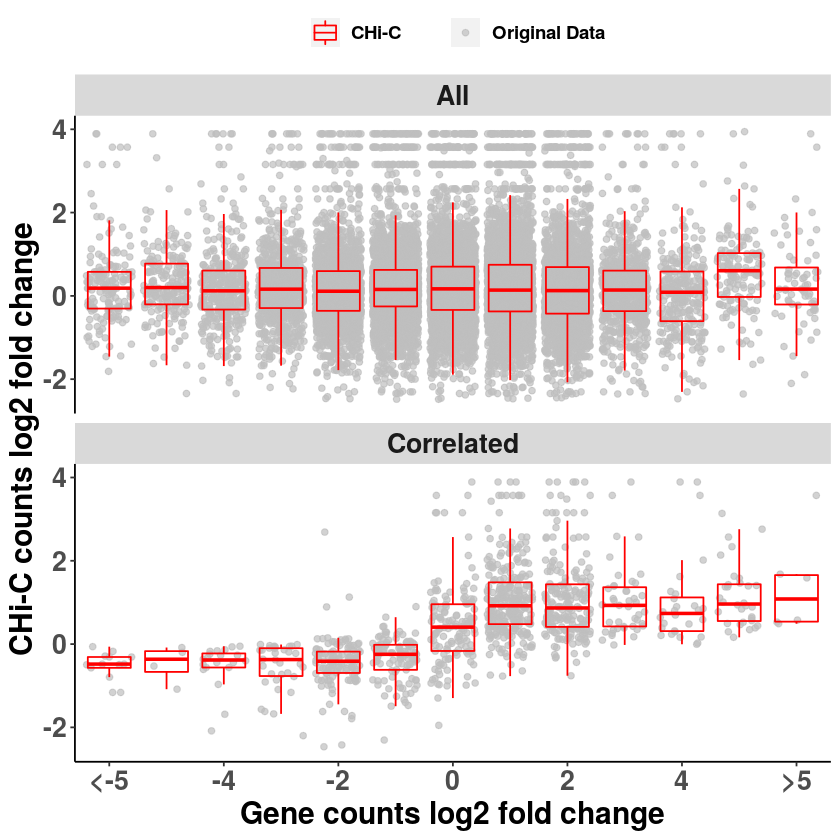

In [61]:
p1 <- ggplot() + theme(panel.background=element_blank(), axis.line=element_line(), 
                       axis.text=element_text(size=16),axis.title=element_text(size=18,face="bold"), 
                       legend.position='top', plot.title=element_text(size=14, face='bold'), 
                       text=element_text(size=14, face='bold'),strip.text.x=element_text(siz=16, face='bold')) + 
geom_jitter(data=data_forplot, aes(x=factor_gene_log2foldchange, y=chic_log2foldchange, color='Original Data'),alpha=0.7)+
geom_boxplot(data=data_forplot, aes(x=factor_gene_log2foldchange, y= chic_log2foldchange,fill='CHi-C'), outlier.shape = NA, color="red", alpha=0.2)+ 
ylim(c(-2.5,4)) + xlab('Gene counts log2 fold change')  + ylab('CHi-C counts log2 fold change') +
  scale_colour_manual(name="",values='grey') + scale_fill_manual(name="",values=cols) +
scale_x_discrete(breaks=c("-6","-4","-2","0","2","4","6"),
        labels=c("<-5","-4","-2","0","2","4", ">5")) + #ggtitle('Fig 4b') +
#ggtitle('log2 fold change between 0 hr and 24 hrs for gene and CHi-C (Fig. 4b)') + 
facet_wrap(.~label, ncol=1)
p1
#ggsave('~/Dropbox (The University of Manchester)/IntegratingATAC-RNA-HiC/Individual_Figures_Files/CHiC_ATACSeq_gene/gene_log2foldchange_chic_0501.pdf', p1)

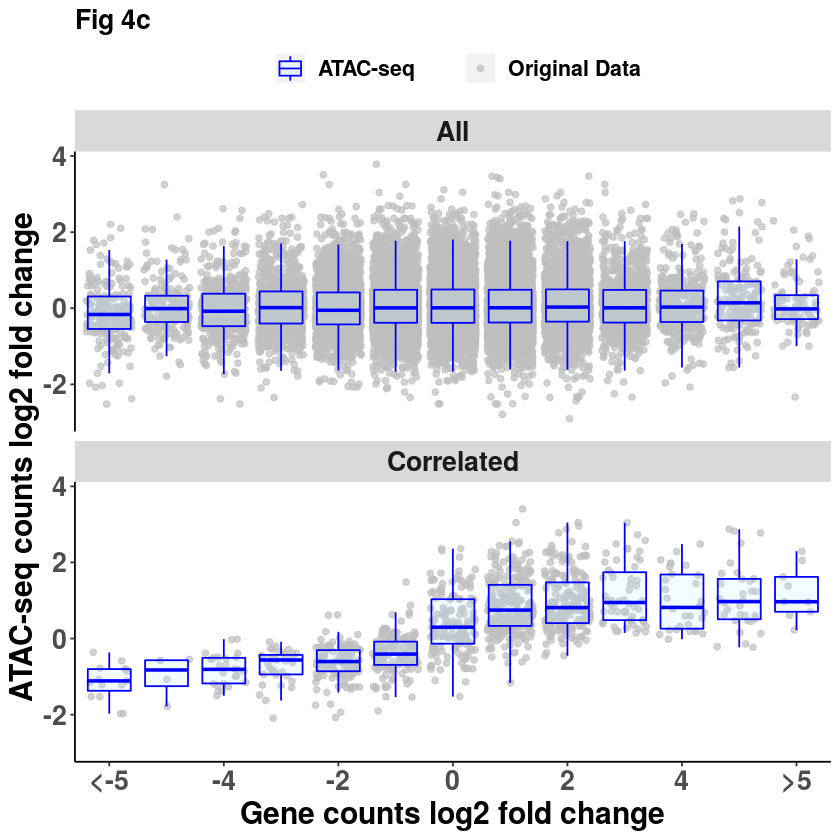

In [59]:
p2 <- ggplot() + theme(panel.background=element_blank(), axis.line=element_line(), 
                       axis.text=element_text(size=16),axis.title=element_text(size=18,face="bold"), 
                       legend.position='top', plot.title=element_text(size=16, face='bold'), 
                       text=element_text(size=16, face='bold'),strip.text.x=element_text(siz=16, face='bold')) + 
geom_jitter(data=data_forplot_atacseq, aes(x=factor_gene_log2foldchange, y=atacseq_log2foldchange, color='Original Data'),alpha=0.7)+
geom_boxplot(data=data_forplot_atacseq, aes(x=factor_gene_log2foldchange, y=atacseq_log2foldchange, fill="ATAC-seq"),
                        outlier.shape = NA, color="blue", alpha=0.2 )+  
xlab('Gene counts log2 fold change')  + ylab('ATAC-seq counts log2 fold change') +
  scale_colour_manual(name="",values='grey') + scale_fill_manual(name="",values=cols_gene) +
scale_x_discrete(breaks=c("-6","-4","-2","0","2","4","6"),
        labels=c("<-5","-4","-2","0","2","4", ">5")) +  ggtitle('Fig 4c') +
#ggtitle('log2 fold change between 0 hr and 24 hr for gene and ATAC-seq (Fig. 4c)') + 
facet_wrap(.~label, ncol=1)
p2
